<a href="https://colab.research.google.com/github/erfunmirzaei/DOL-Project1/blob/main/Project1_DOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition  


In this project, we implemented federated learning algorithms as samples of the decentralized optimization algorithms for the case when client datasets are i.i.d. or non-iid. Then, compare the results with the centralized version.

For this purpose, a convolution neural network and the cifar10 dataset are used. In the first part, we trained the network in a centralized manner, as in the standard cases in deep learning. We implemented the FedAvg algorithm, one of the most famous algorithms in federated learning, when the client datasets are iid. In the following, the iid assumption was discarded. Thus, we split datasets in a non-iid manner. Therefore for non-iid datasets, we implemented the FedProx algorithm and compared the results to the FedAvg Algorithm.

In [1]:
#Importing required libraries 
import numpy as np
import matplotlib.pyplot as plt
import math 
import os, sys 
import random 
import copy
import string

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
device

device(type='cuda', index=0)

## Networks

In [4]:
class Deep_CNN(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, num_classes):
        super(Deep_CNN, self).__init__() 

        # First layer
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # First Hidden layer 
        self.fc1 = nn.Linear(16 * 5 *5, 120)
        
        # Second Hidden layer
        self.fc2 = nn.Linear(120, 84)
        
        # Classifier 
        self.fc3 = nn.Linear(84,num_classes)

        # Activation Function 
        self.relu = nn.ReLU()     

        # Dropout 
        self.dropout = nn.Dropout( p= 0.2)
           
    
    def forward(self,x):
        # First Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer 
        x = self.fc1(x)
        x = self.relu(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.relu(x)
   
        # Classifier
        x = self.fc3(x)

        return x


In [5]:
class PerFed_MAML_Network(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, input_dim, num_classes):
        super(PerFed_MAML_Network, self).__init__()
        
        self.input_dim = input_dim

        # First Hidden layer 
        self.fc1 = nn.Linear(input_dim, 80)

        # Second Hidden layer
        self.fc2 = nn.Linear(80, 60)
        
        # Classifier 
        self.fc3 = nn.Linear(60,num_classes)

        # Activation Function 
        self.elu = nn.ELU()        

        # Dropout
        self.dropout = nn.Dropout(p = 0.3)

    def forward(self,x):
        # 
        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer 
        x = self.fc1(x)
        x = self.elu(x)
        #x = self.dropout(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.elu(x)
        #x = self.dropout(x)

        # Classifier 
        x = self.fc3(x)

        return x

# Centralized

## Preprocessing 

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
max_epochs = 1000
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


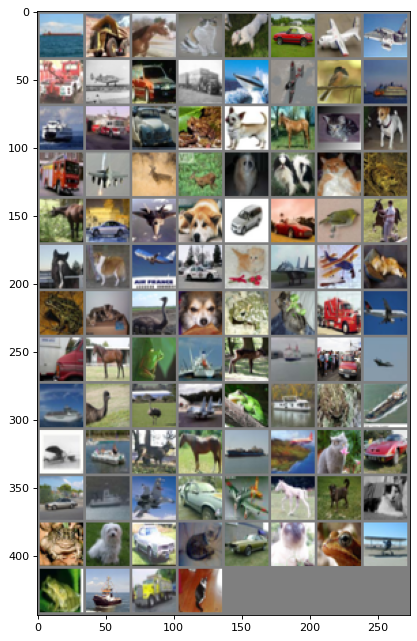

 ship truck horse   cat   dog   car plane plane truck plane   car truck  ship plane  bird  ship  ship truck   car  frog   dog horse   cat   dog truck plane  deer  deer   dog   dog   cat  frog horse   car plane   dog   car   car  bird horse horse   dog plane   car   cat plane plane   cat  frog   cat  bird   dog  frog   cat truck plane truck horse  frog  ship  deer  ship   car plane  ship  bird  bird plane  frog  ship  frog  ship plane  ship  deer horse  ship plane   cat   car   car  ship plane   car plane horse   dog   cat  frog   dog   car   cat   car   cat  frog plane  frog  ship truck   cat


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 10), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Sanity Check 
(try to overfit on a mini batch)

In [8]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

dataiter = iter(trainloader)
train_data, train_labels = next(dataiter)

val_dataiter = iter(testloader)
val_data, val_labels = next(val_dataiter)

max_epochs = 1000

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    # Transfer to GPU
    train_data, train_labels = train_data.to(device), train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(train_data)

    loss = criterion(batch_train_outputs, train_labels.long())
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

    if train_cnt % 100 == 99:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for val_data, val_labels in tqdm(validation_generator):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(val_data)
        
        val_loss = criterion(batch_outputs, val_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

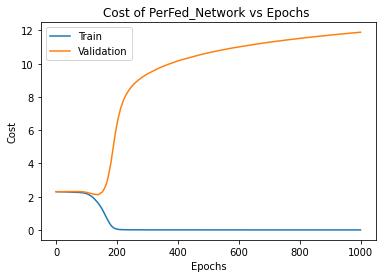

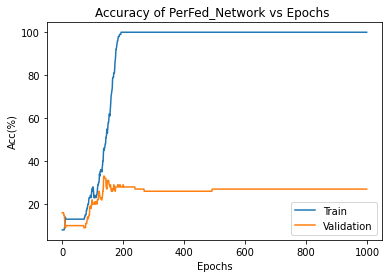

In [9]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of PerFed_Network vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of PerFed_Network vs Epochs ")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Centeralized Training 

In [10]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.05, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)
        # print(batch_train_outputs.shape, train_labels.shape)
        # break
        loss = criterion(batch_train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(val_data)
            
            val_loss = criterion(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    # scheduler.step()      
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.168641
Cost of Train data after 200 iterations in epoch 1 : 1.810019
Cost of Train data after 300 iterations in epoch 1 : 1.617922
Cost of Train data after 400 iterations in epoch 1 : 1.573385
Cost of Train data after 500 iterations in epoch 1 : 1.485284


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.479389


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.442207
Cost of Train data after 200 iterations in epoch 2 : 1.402277
Cost of Train data after 300 iterations in epoch 2 : 1.403886
Cost of Train data after 400 iterations in epoch 2 : 1.365419
Cost of Train data after 500 iterations in epoch 2 : 1.320250


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.346492


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.280759
Cost of Train data after 200 iterations in epoch 3 : 1.274805
Cost of Train data after 300 iterations in epoch 3 : 1.285203
Cost of Train data after 400 iterations in epoch 3 : 1.285311
Cost of Train data after 500 iterations in epoch 3 : 1.235345


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.314094


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.176999
Cost of Train data after 200 iterations in epoch 4 : 1.185495
Cost of Train data after 300 iterations in epoch 4 : 1.175461
Cost of Train data after 400 iterations in epoch 4 : 1.214485
Cost of Train data after 500 iterations in epoch 4 : 1.205359


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.244194


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.103560
Cost of Train data after 200 iterations in epoch 5 : 1.165687
Cost of Train data after 300 iterations in epoch 5 : 1.132887
Cost of Train data after 400 iterations in epoch 5 : 1.180692
Cost of Train data after 500 iterations in epoch 5 : 1.149304


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.283480


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 1.077327
Cost of Train data after 200 iterations in epoch 6 : 1.107023
Cost of Train data after 300 iterations in epoch 6 : 1.104609
Cost of Train data after 400 iterations in epoch 6 : 1.122095
Cost of Train data after 500 iterations in epoch 6 : 1.112841


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.192412


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 1.038610
Cost of Train data after 200 iterations in epoch 7 : 1.076251
Cost of Train data after 300 iterations in epoch 7 : 1.084073
Cost of Train data after 400 iterations in epoch 7 : 1.087919
Cost of Train data after 500 iterations in epoch 7 : 1.118308


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.191881


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 1.015146
Cost of Train data after 200 iterations in epoch 8 : 1.042880
Cost of Train data after 300 iterations in epoch 8 : 1.058634
Cost of Train data after 400 iterations in epoch 8 : 1.062980
Cost of Train data after 500 iterations in epoch 8 : 1.078489


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.299419


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.989584
Cost of Train data after 200 iterations in epoch 9 : 1.002829
Cost of Train data after 300 iterations in epoch 9 : 1.056821
Cost of Train data after 400 iterations in epoch 9 : 1.074731
Cost of Train data after 500 iterations in epoch 9 : 1.095005


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.214632


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.981067
Cost of Train data after 200 iterations in epoch 10 : 0.999979
Cost of Train data after 300 iterations in epoch 10 : 1.034167
Cost of Train data after 400 iterations in epoch 10 : 1.062249
Cost of Train data after 500 iterations in epoch 10 : 1.055911


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.273022


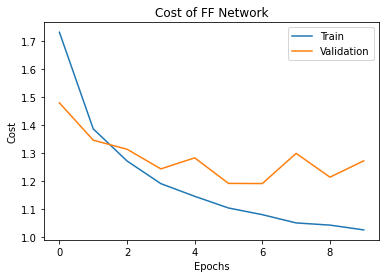

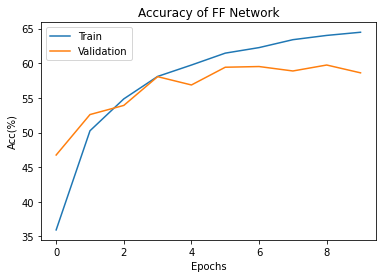

In [11]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of FF Network")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of FF Network")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

In [12]:
# Model 
Net2 = Deep_CNN(10)
Net2.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(Net2.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses2 = []
validation_losses2 = []

train_accs2 = []
val_accs2 = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer2.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net2(train_data)

        loss = criterion2(batch_train_outputs, train_labels)
        loss.backward()
        optimizer2.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net2(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    # scheduler.step()      
    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.288433
Cost of Train data after 200 iterations in epoch 1 : 2.115829
Cost of Train data after 300 iterations in epoch 1 : 1.883234
Cost of Train data after 400 iterations in epoch 1 : 1.744553
Cost of Train data after 500 iterations in epoch 1 : 1.611840


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.595319


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.533521
Cost of Train data after 200 iterations in epoch 2 : 1.493528
Cost of Train data after 300 iterations in epoch 2 : 1.443538
Cost of Train data after 400 iterations in epoch 2 : 1.423368
Cost of Train data after 500 iterations in epoch 2 : 1.368763


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.332018


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.342702
Cost of Train data after 200 iterations in epoch 3 : 1.308330
Cost of Train data after 300 iterations in epoch 3 : 1.311478
Cost of Train data after 400 iterations in epoch 3 : 1.269746
Cost of Train data after 500 iterations in epoch 3 : 1.294370


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.246299


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.220458
Cost of Train data after 200 iterations in epoch 4 : 1.184233
Cost of Train data after 300 iterations in epoch 4 : 1.190317
Cost of Train data after 400 iterations in epoch 4 : 1.190207
Cost of Train data after 500 iterations in epoch 4 : 1.179757


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.169655


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.138947
Cost of Train data after 200 iterations in epoch 5 : 1.119046
Cost of Train data after 300 iterations in epoch 5 : 1.119232
Cost of Train data after 400 iterations in epoch 5 : 1.119910
Cost of Train data after 500 iterations in epoch 5 : 1.124486


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.145746


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 1.069730
Cost of Train data after 200 iterations in epoch 6 : 1.044621
Cost of Train data after 300 iterations in epoch 6 : 1.062120
Cost of Train data after 400 iterations in epoch 6 : 1.043140
Cost of Train data after 500 iterations in epoch 6 : 1.048317


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.113182


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.999566
Cost of Train data after 200 iterations in epoch 7 : 1.006466
Cost of Train data after 300 iterations in epoch 7 : 1.002566
Cost of Train data after 400 iterations in epoch 7 : 1.005364
Cost of Train data after 500 iterations in epoch 7 : 0.996368


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.110254


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.938381
Cost of Train data after 200 iterations in epoch 8 : 0.958440
Cost of Train data after 300 iterations in epoch 8 : 0.970378
Cost of Train data after 400 iterations in epoch 8 : 0.960059
Cost of Train data after 500 iterations in epoch 8 : 0.965337


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.077170


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.878959
Cost of Train data after 200 iterations in epoch 9 : 0.900582
Cost of Train data after 300 iterations in epoch 9 : 0.915925
Cost of Train data after 400 iterations in epoch 9 : 0.930402
Cost of Train data after 500 iterations in epoch 9 : 0.926871


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.073727


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.868840
Cost of Train data after 200 iterations in epoch 10 : 0.872161
Cost of Train data after 300 iterations in epoch 10 : 0.863185
Cost of Train data after 400 iterations in epoch 10 : 0.903516
Cost of Train data after 500 iterations in epoch 10 : 0.875040


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.119159


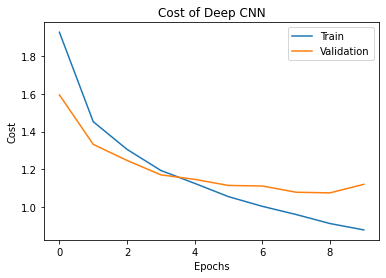

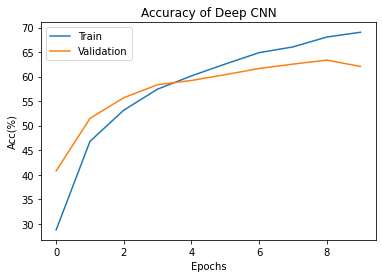

In [13]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs2)
    plt.plot(val_accs2)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [14]:
PATH = 'PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

# Federated Learning (IID) 

## Split Client's datasets

In [15]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)

batch_size2 = 50

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform2)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)

testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size2,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n = 100
N = len(trainset2.__dict__['targets'])
N_prime = len(testset2.__dict__['targets']) 
n_i = N // n
n_i_prime = N_prime // n

train_sets2 = []
test_sets2 = []
for i in range(n):
    subset1, trainset2 = random_split(trainset2, (n_i ,N - n_i))
    train_sets2.append(subset1)
    N = N - n_i 

    subset2, testset2 = random_split(testset2, (n_i_prime ,N_prime - n_i_prime))
    test_sets2.append(subset2)
    N_prime = N_prime - n_i_prime 

train_loaders2 = [torch.utils.data.DataLoader(train_sets2[i], batch_size=batch_size2,
                                          shuffle=True, num_workers=2) for i in range(n)] 


test_loaders2 = [torch.utils.data.DataLoader(test_sets2[i], batch_size=batch_size2,
                                          shuffle=True, num_workers=2) for i in range(n)]

Files already downloaded and verified
Files already downloaded and verified


In [16]:
labels = []
for train_data, train_labels in train_loaders2[9]:
    labels.append(train_labels)

In [17]:
x = 0
for i in labels:
    for j in i:
        if j == 2:
            x += 1

print(x)

43


## Primal (FedAvg)

In [18]:
class FedAvg_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):   
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        
        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## FedAvg Training 

In [ ]:
# Model 
Net3 = Deep_CNN(10)
Net3.to(device)

# # Define Loss function and Optimizer
criterion3 = nn.CrossEntropyLoss()

train_losses3 = []
validation_losses3 = []

train_accs3 = []
val_accs3 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net3.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net3).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net3.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net3(val_data)
            
            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 54 in round 1 for 5 epochs: 2.301427
Cost of Train data for client 49 in round 1 for 5 epochs: 2.296252
Cost of Train data for client 42 in round 1 for 5 epochs: 2.297819
Cost of Train data for client 12 in round 1 for 5 epochs: 2.296271
Cost of Train data for client 40 in round 1 for 5 epochs: 2.297568
Cost of Train data for client 95 in round 1 for 5 epochs: 2.297441
Cost of Train data for client 70 in round 1 for 5 epochs: 2.298825
Cost of Train data for client 63 in round 1 for 5 epochs: 2.300846
Cost of Train data for client 17 in round 1 for 5 epochs: 2.298187
Cost of Train data for client 35 in round 1 for 5 epochs: 2.291591
----------
Cost of Train data for in round 1: 2.297623
Cost of Validation data for in round 1: 2.298142
Acc of Train data for in round 1: 12.084001
Acc of Validation data for in round 1: 11.450008
----------
Cost of Train data for client 10 in round 2 for 5 epochs: 2.288988
Cost of Train data for client 50 in round 2 for 5 epoch

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses3)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs3)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Primal_1.pth'
torch.save(Net3.state_dict(), PATH)

In [ ]:
# Model 
Net4 = Deep_CNN(10)
Net4.to(device)

# # Define Loss function and Optimizer
criterion4 = nn.CrossEntropyLoss()

train_losses4 = []
validation_losses4 = []

train_accs4 = []
val_accs4 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.02
w_dict = copy.deepcopy(Net4.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net4).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net4.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net4(val_data)
            
            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses4)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs4)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Primal_2.pth'
torch.save(Net4.state_dict(), PATH)

# Federated Learning (Non-IID Dataset)

## Split Clients' dataset

In [ ]:
class Cifar10(torch.utils.data.Dataset):
    
    def __init__(self, train_set, list_IDs):
        self.train_set = train_set
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self,index):
        ind = self.list_IDs[index]
        return self.train_set[ind]

In [ ]:
def cifar_noniid(dataset, num_users,  batch_size):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    n = num_users
    n_i = len(dataset) // n // 2 # each class items per client 
    cifar_labels = { i: [] for i in range(10) }

    for i in range(len(dataset)):
        cifar_labels[dataset[i][1]].append(i)

    for i in range(10):
        cifar_labels[i] = [cifar_labels[i][x:x+n_i] for x in range(0, len(cifar_labels[i]), n_i)]
    
    users_dict = dict()
    i = 0
    for user in range(n):
        if len(cifar_labels[i]) > 0:    
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]
        
        else :
            i = i + 2
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]

    train_loaders = [torch.utils.data.DataLoader(Cifar10(dataset,users_dict[i]), batch_size=batch_size,shuffle=True, num_workers = 2) for i in range(n)] 
    
    return train_loaders

In [ ]:
transform3 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
n = 100
batch_size3 = 50

trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform3)

trainloader3 = torch.utils.data.DataLoader(trainset3, batch_size=batch_size3,
                                          shuffle= True, num_workers=2)

testset3 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform3)

testloader3 = torch.utils.data.DataLoader(testset3, batch_size=batch_size3,
                                         shuffle=False, num_workers=2)

train_loaders3 = cifar_noniid(trainset3, n, batch_size3)



In [ ]:
labels = []

for train_data, train_labels in train_loaders3[20]:
    labels.append(train_labels)

In [ ]:
x = 0
for i in labels:
    for j in i:
        if j == 3:
            x += 1

print(x)

## FedProx 

In [ ]:
class FedAvg_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):   
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        
        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict
    
    
class FedProx_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def loss_function(self, net, w_t,batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)

        loss2 = 0
        for l in w_dict.keys():
            loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2)
        
        return loss1 + (mu /2) * loss2

    def update(self, net, max_epochs, lr, mu):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        w_t = copy.deepcopy(net.state_dict())

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss,  train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.loss_function(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs)/len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## Non-IID Training

### FedAvg Training

In [ ]:
# Model 
Net6 =  Deep_CNN(10)
Net6.to(device)

# Define Loss function and Optimizer
criterion6 = nn.CrossEntropyLoss()

train_losses6 = []
validation_losses6 = []

train_accs6 = []
val_accs6 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net6.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net6).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net6.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net6(val_data)
            
            val_loss = criterion6(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    train_losses6.append(running_trainloss / train_cnt)
    train_accs6.append(train_acc / train_cnt * 100)
    validation_losses6.append(running_valloss / val_cnt)
    val_accs6.append(val_acc / val_cnt * 100)

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses6)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs6)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Non_IID_1.pth'
torch.save(Net6.state_dict(), PATH)

### FedProx Training

In [ ]:
# Model 
Net5 =  Deep_CNN(10)
Net5.to(device)

# Define Loss function and Optimizer
criterion5 = nn.CrossEntropyLoss()

train_losses5 = []
validation_losses5 = []

train_accs5 = []
val_accs5 = []

max_rounds = 50
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
w_dict = copy.deepcopy(Net5.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)
            
            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

In [ ]:

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)
            
            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses5)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs5)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Non_IID_2.pth'
torch.save(Net5.state_dict(), PATH)